
# 기초

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from scipy.integrate import simpson
from PIL import Image

# DSP
def square_wave(x, start, end):
    return np.where((x >= start) & (x < end), 1, 0)

def ctft(x, signal, freq_range):
    ft = []
    for freq in freq_range:
        integrand = signal * np.exp(-1j * 2 * np.pi * freq * x)
        ft_value = simpson(integrand, x=x)
        ft.append(ft_value)
    return np.array(ft)

def get_magnitude_phase(img):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = np.abs(dft_shift)
    phase_spectrum = np.angle(dft_shift)
    return magnitude_spectrum, phase_spectrum

def get_ideal_lowpass_filter(shape, cutoff):
    mask = np.zeros(shape, np.uint8)
    for u in range(shape[0]):
        for v in range(shape[1]):
            D = np.sqrt((u - shape[0]//2)**2 + (v - shape[1]//2)**2)
            if D <= cutoff:
                mask[u, v] = 1
    return mask

def get_butterworth_lowpass_filter(shape, cutoff, order=2):
    mask = np.zeros(shape, np.float32)
    for u in range(shape[0]):
        for v in range(shape[1]):
            D = np.sqrt((u - shape[0]//2)**2 + (v - shape[1]//2)**2)
            mask[u, v] = 1 / (1 + (D / cutoff)**(2*order))
    return mask

# Image Processing
def apply_dft_filter(img):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = np.abs(dft_shift)
    phase_spectrum = np.angle(dft_shift)
    return magnitude_spectrum, phase_spectrum

def apply_conv_filter(img, kernel):
    result = np.zeros(img.shape, dtype=np.float32)
    padded_img = np.pad(img, ((kernel.shape[0]//2,kernel.shape[0]//2), (kernel.shape[1]//2,kernel.shape[1]//2)), mode='constant', constant_values=0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded_img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i,j] = np.sum(region * kernel)
    return result

def apply_mul_filter(img, kernel):
    # result = np.zeros(img.shape, dtype=np.float32)
    # padded_img = np.pad(img, ((kernel.shape[0]//2,kernel.shape[0]//2), (kernel.shape[1]//2,kernel.shape[1]//2)), mode='constant', constant_values=0)
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         region = padded_img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
    #         result[i,j] = np.sum(region * kernel)
    # return result

# Debug
def load_image(dir):
    return cv2.imread(dir, cv2.IMREAD_GRAYSCALE)

def plot_plots(x, y):
    plt.figure(figsize=(4*len(x), 4))
    for i in range(len(x)):
        plt.subplot(1, len(x), 1+i)
        plt.plot(x[i], y[i])
    plt.show()

def plot_images(imgs, cmap=cm.gray):
    plt.figure(figsize=(4*len(imgs), 4))
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), 1+i)
        plt.imshow(np.clip(imgs[i], 0, 255).astype(np.uint8), cmap=cmap)
    plt.show()
    

## DSP

#### Fourier Transform of square wave

/home/kyun/anaconda3/envs/ai_240402/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kyun/anaconda3/envs/ai_240402/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


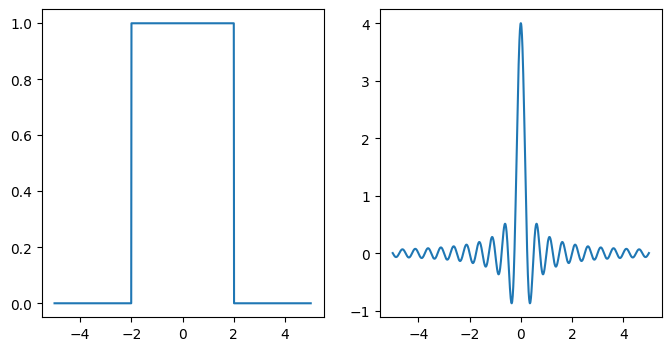

In [5]:
# Fourier Transform of square wave
if __name__ == "__main__":
    T = 2
    x = np.linspace(-5, 5, 1000)
    pulse = square_wave(x, start=-T, end=T)
    freq_range = np.linspace(-5, 5, 1000)
    ft_pulse = ctft(x, pulse, freq_range)

    x = [x, freq_range]
    y = [pulse, ft_pulse]
    plot_plots(x, y)

#### Fourier series of discrete time periodic signals

In [6]:
if __name__ == "__main__":
    x = np.array([1,1,0,0])
    X = np.zeros(len(x), dtype=complex)
    for i in range(len(X)):
        for j in range(len(x)):
            X[i] += x[j] * np.exp(-2j * np.pi * i * j/len(x))
        X[i] /= len(x)
    
    for i in range(len(X)):
        print(f"X[{i}] = {X[i]:.2f}")

X[0] = 0.50+0.00j
X[1] = 0.25-0.25j
X[2] = 0.00-0.00j
X[3] = 0.25+0.25j


#### Fourier spectrum and phase

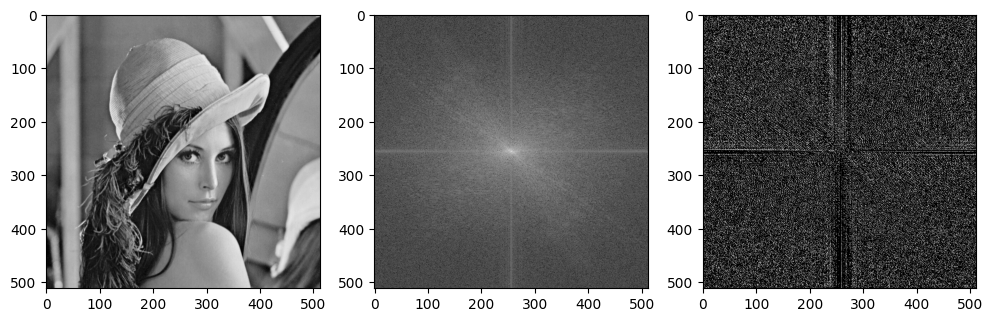

In [16]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    magnitude_spectrum, phase_spectrum = get_magnitude_phase(img)

    imgs = [img, np.log(magnitude_spectrum+1), phase_spectrum]
    plot_images(imgs)

#### apply Ideal low pass filters & Butterworth lowpass filter

In [4]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    cutoff = 30 # cutoff frequency
    order = 2   # Butterworth filter order

    ideal_lowpass_filter = get_ideal_lowpass_filter(img.shape, cutoff)
    butterworth_lowpass_filter = get_butterworth_lowpass_filter(img.shape, cutoff, order)

    ideal_lowpass_filtered_img = apply_filter(img, ideal_lowpass_filter)
    butterworth_lowpass_filtered_img = apply_filter(img, butterworth_lowpass_filter)

    imgs = [img, ideal_lowpass_filtered_img, butterworth_lowpass_filtered_img]
    plot_images(imgs)


KeyboardInterrupt: 

## Image Processing

##### Low Pass Filter

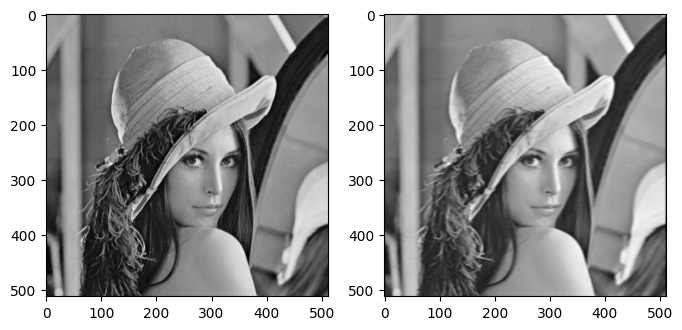

In [8]:
# Low Pass Filter
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    low_pass_kernel = np.array([[0.2,0.2,0.2,0.2,0.2]])
    horizontal_sobel_kernel = np.array([[-1,0,1],
                                        [-2,0,2],
                                        [-1,0,1]])
    low_pass_filtered_img = apply_conv_filter(img, low_pass_kernel)
    imgs = [img, low_pass_filtered_img]
    plot_images(imgs)
